# Paris NWP subhourly time height plots
Example for how to extract model level data from file/fdb/polytope and create a time-hight plots. Note that fdb is only available on ECMWF atos.

The exvper=aac6 is a 6h long forecast with output every 30s

In [1]:
# Import necessary libraries
import os
import earthkit.data
import hashlib

In [20]:
# Define your input source as file, fdb or polytope
# Use CUSTOM_FILENAME with full path for file input
INPUT_SOURCE = "fdb"
CUSTOM_FILENAME = None
CUSTOM_FILEPATH = os.environ["SCRATCH"]
# Select parameter from t,u,v,q,wz
PARAM = "wz"
LEVTOP = 70  
polytope_address="polytope.lumi.apps.dte.destination-earth.eu"

In [21]:
# Client authentification, use if required
#from polytope.api import Client
#client = Client(address=polytope_address)

In [22]:
# Define the request, note that we only extract levtop -> 90 levels to reduce the data amount
params = {
    "crw": 75,
    "cswc": 76,
    "z": 129,
    "t": 130,
    "u": 131,
    "v": 132,
    "q": 133,
    "clwc": 246,
    "ciwc": 247,
    "cc": 248,
    "grle": 260028,
    "tke": 260155,
    "wz": 260238,
}

request= {
    "class": "d1",
    "dataset": "on-demand-extremes-dt",
    "expver": "aac6",
    "stream": "oper",
    "date": "2023-08-20",
    "time": "1200",
    "type": "fc",
    "georef": "u09tvk",
    "levtype": "ml",
    "step": "0/to/6h/by/15m",
    "levelist": list(range(LEVTOP,91)),
    "param": [params["z"],params[PARAM]],
}

In [23]:
def check_fdb_env():
    # Make sure we have the correct FDB environment
    if INPUT_SOURCE == "fdb":
        os.environ["FDB_HOME"] = "/home/fdbtest"
    try:
        os.environ["FDB5_HOME"] = os.environ["ECMWF_TOOLBOX_DIR"]
    except:
        raise KeyError("Make sure to load ecmwf-toolbox before your start")

In [24]:
def construct_filename(request):
   # Construct the filename to cache
    
    key_list = []
    for key,x in request.items():
        if isinstance(x,str):
            key_list.append(x.replace("/","_"))
            #print(f"Add {key}={x}")
        elif isinstance(x,list):
            if any(not isinstance(y, str) for y in x):
               x = [str(y) for y in x]
            combined = "\0".join(x).encode("utf-8")
            hash = hashlib.sha1(combined).hexdigest()[:8]
            key_list.append(hash)
            #print(f"Hashed {key}={hash}")
    filename = "_".join(key_list) + ".grib2"
    data_target_path = f"{CUSTOM_FILEPATH}/{filename}"
    return data_target_path

In [25]:
def request_data(request):
    # Run the request
    data_target_path = construct_filename(request)
    if not os.path.isfile(data_target_path):
        if INPUT_SOURCE == "polytope":
            data = earthkit.data.from_source("polytope", "destination-earth", request, address=polytope_address, stream=False)
        elif INPUT_SOURCE == "fdb":
            check_fdb_env()
            data = earthkit.data.from_source("fdb", request, read_all=True)
        print("Save data to:", data_target_path)
        data.to_target("file", data_target_path)
    else:
        if CUSTOM_FILENAME is not None:
            data_target_path = CUSTOM_FILENAME
        print("Read:", CUSTOM_FILENAME)
        data = earthkit.data.from_source("file", data_target_path)
    return data

In [42]:
def plot_map(x):
 chart = earthkit.plots.Map()
 chart.quickplot(x)
 chart.coastlines()
 chart.land()
 chart.borders()
 chart.gridlines()
 try:
    chart.legend()
 except:
    pass
 chart.show()

In [35]:
data = request_data(request)
data.ls()

Read: None


,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,z,hybrid,70,20230820,1200,0s,fc,None,lambert_lam
1,ecmf,wz,hybrid,70,20230820,1200,0s,fc,None,lambert_lam
2,ecmf,z,hybrid,71,20230820,1200,0s,fc,None,lambert_lam
3,ecmf,wz,hybrid,71,20230820,1200,0s,fc,None,lambert_lam
4,ecmf,z,hybrid,72,20230820,1200,0s,fc,None,lambert_lam
...,...,...,...,...,...,...,...,...,...,...
1045,ecmf,wz,hybrid,88,20230820,1200,6,fc,None,lambert_lam
1046,ecmf,z,hybrid,89,20230820,1200,6,fc,None,lambert_lam
1047,ecmf,wz,hybrid,89,20230820,1200,6,fc,None,lambert_lam
1048,ecmf,z,hybrid,90,20230820,1200,6,fc,None,lambert_lam


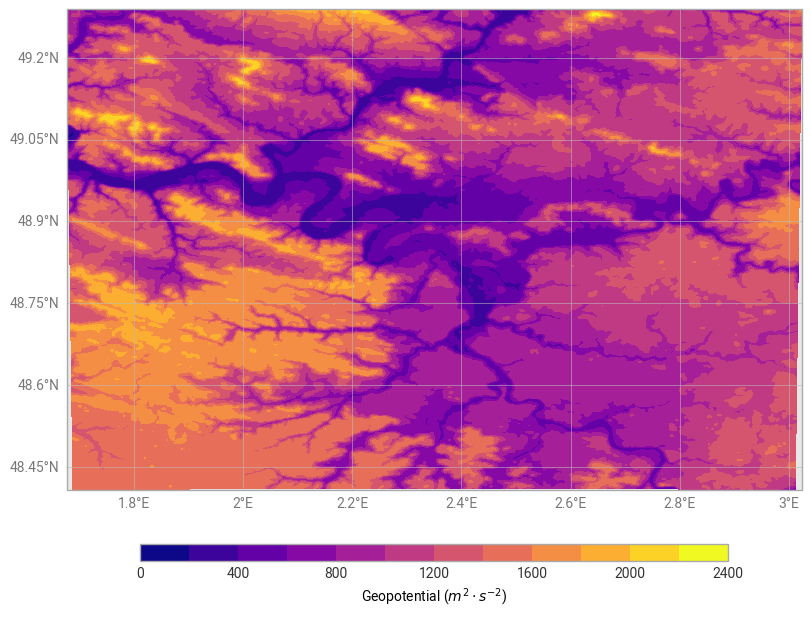

In [43]:
plot_map(data.sel({"shortName": "z", "level":90, "stepRange": "0s"}))

In [27]:
# Convert to xarray
atm = data.sel({"typeOfLevel": "hybrid"}).to_xarray()
atm["step"] = data.sel({"typeOfLevel": "hybrid"}).datetime()["valid_time"]

In [28]:
# Extract a single point and scale z
x0 = 250
y0 = 250
new = atm[PARAM].isel(x=x0,y=y0)
new["z"] = (atm["z"].isel(x=x0,y=y0) / 9.81)

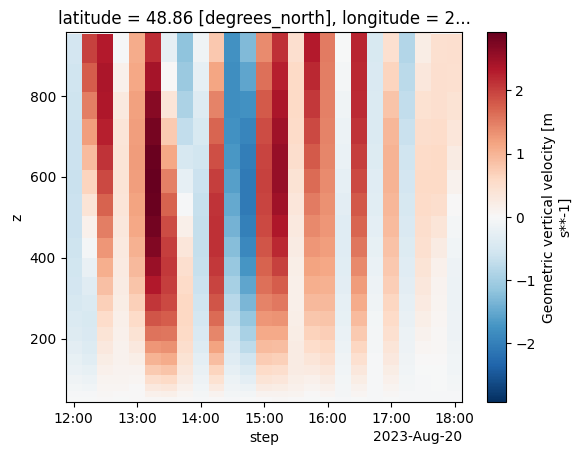

In [29]:
# Time to plot!
new.plot.pcolormesh(x="step",y="z")